# Dat121 project


### Imports

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import expit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

### Loading dataset

In [34]:
# Loading dataset
data = pd.read_csv('heart.csv', low_memory=False)

# copy of data
raw_df = data.copy()

# Defining input data and the target values
X = raw_df.drop(columns=[raw_df.columns[-1]])  
y =  raw_df[raw_df.columns[-1]] 


### Raw data exploration

              age         sex          cp      trtbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg    thalachh        exng     oldpeak         slp         caa  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

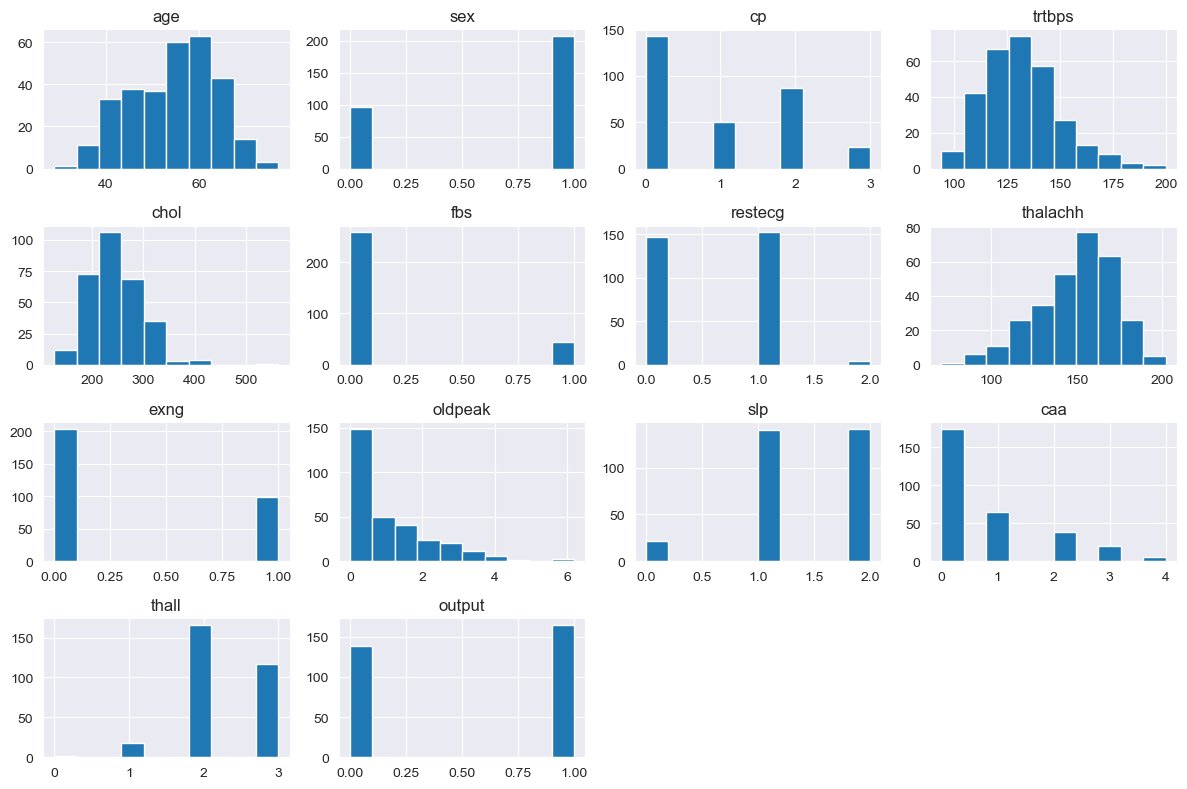

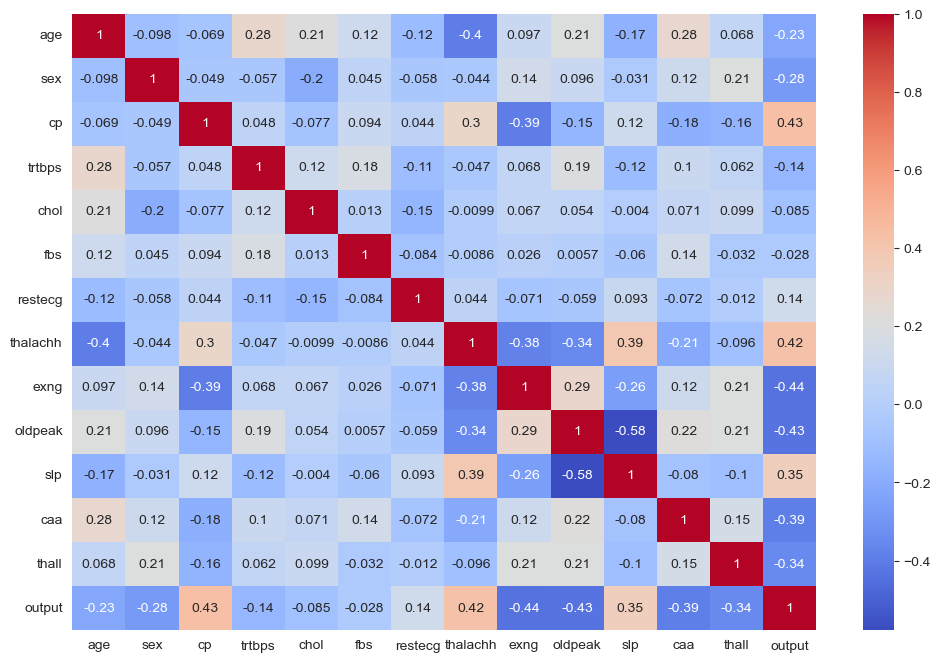

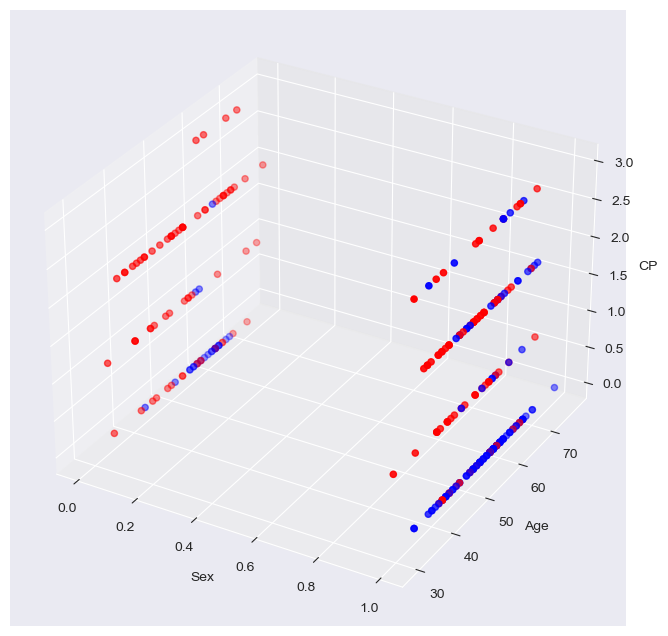

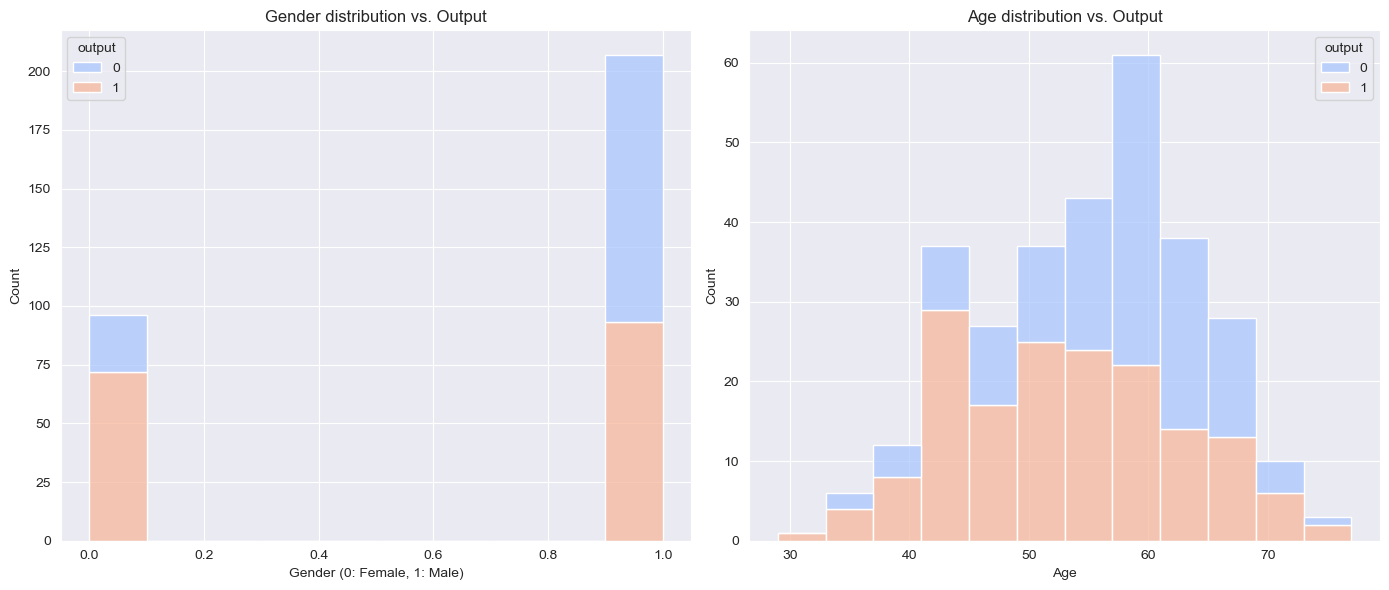

In [3]:
# Descriptive statistics
descr_stats= raw_df.describe()
print(descr_stats)

# Searching for missing values
print("Missing values in dataset:\n", raw_df.isnull().sum())
# no missing values in the dataset.

# Histogram for features in the dataset
raw_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Correlation heatmap
corrmat = raw_df.corr()
top_corr = corrmat.index
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(raw_df[top_corr].corr(),annot=True,cmap="coolwarm")

# 3D Scatterplot 
# For features age, sex and cp (chestpain type), colored by output.
# Sex = 0 indicates female, 
# Sex = 1 indicates male.
# Cp have values 0, 1, 2 or 3. 0 being typical angina, 3 being no symptoms. 
# Output = 0 means lesser chance of heartattack, colored blue.
# Output = 1 means higher chance for heart attack, colored red.

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x = raw_df['sex']
y = raw_df['age']
z = raw_df['cp']
c = raw_df['output']  

# Defining colors of the dots
colors = np.where(c == 0, 'blue', 'red')

# Scatter plot with color based on 'output'
ax.scatter(x, y, z, c=colors)
ax.set_xlabel('Sex')
ax.set_ylabel('Age')
ax.set_zlabel('CP')
plt.show()


# plot of distrubution of genders and the output in dataset
def plot_gender_vs_output(data):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(data=data, x="sex", hue="output", multiple="stack", ax=ax[0], palette="coolwarm", kde=False)
    ax[0].set_title("Gender distribution vs. Output")
    ax[0].set_xlabel("Gender (0: Female, 1: Male)")
    ax[0].set_ylabel("Count")

    sns.histplot(data=data, x="age", hue="output", multiple="stack", ax=ax[1], palette="coolwarm", kde=False)
    ax[1].set_title("Age distribution vs. Output")
    ax[1].set_xlabel("Age")
    ax[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_gender_vs_output(raw_df)


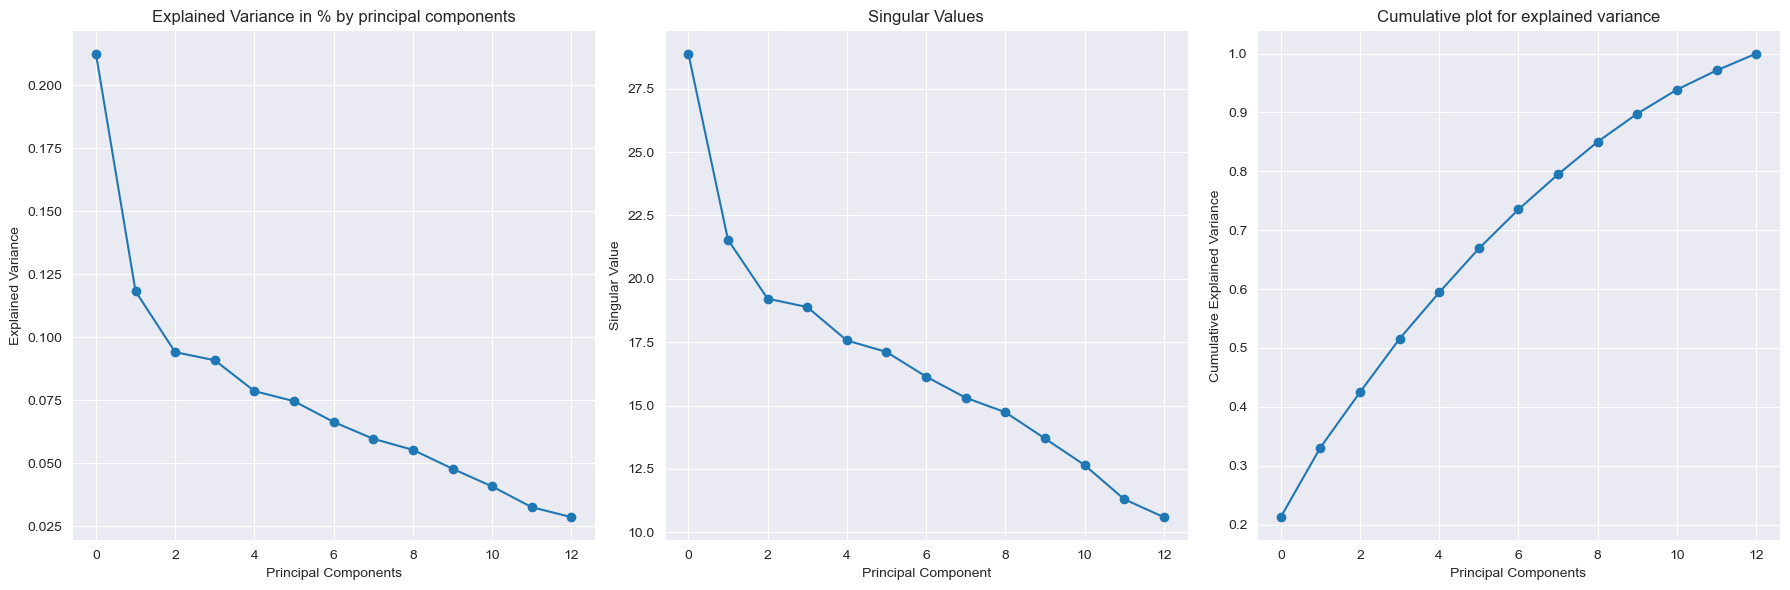

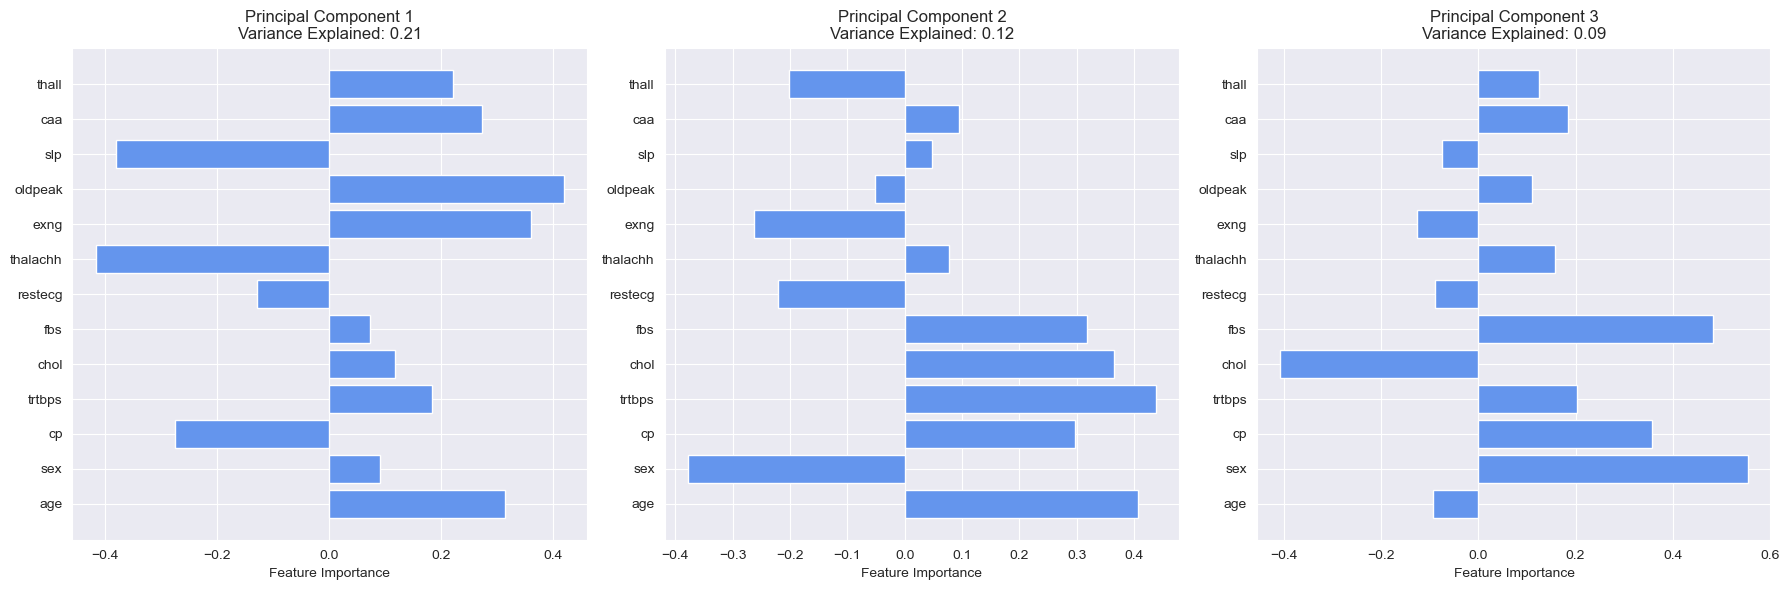

In [35]:
# PCA of scaled data to explore data and further reduce dimensionality

# Standardizing the raw data
X =(X - X.mean()) / X.std()

# Performing PCA and fitting on data
pca = PCA(n_components=13)
pca.fit(X)

loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(X.columns))],
index=X.columns)

# Plot of prinipal components and explained variance
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.grid(True)
ax1.plot(pca.explained_variance_ratio_, marker='o')
ax1.set_ylabel('Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.grid(True)
ax1.set_title('Explained Variance in % by principal components')

# Singular values plot
ax2.grid(True)
ax2.set_title("Singular Values")
ax2.plot(pca.singular_values_, marker='o')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Singular Value')

# Cumulative plot
variance = np.cumsum(pca.explained_variance_ratio_)
ax3.grid(True)
ax3.plot(variance, marker='o')
ax3.set_ylabel('Cumulative Explained Variance')
ax3.set_xlabel('Principal Components')
ax3.grid(True)
ax3.set_title('Cumulative plot for explained variance')

plt.tight_layout()
plt.show()

# Plot of pca components against feature importance
def plot_pca_components(pca, X):
    explained_variance = pca.explained_variance_ratio_
    components = pca.components_

    # Plotting the first three principal components:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i in range(3):
        ax = axes[i]
        ax.barh(X.columns, components[i], color='cornflowerblue')
        ax.set_title(f'Principal Component {i+1}\nVariance Explained: {explained_variance[i]:.2f}')
        ax.set_xlabel('Feature Importance')

    plt.tight_layout()
    plt.show()

plot_pca_components(pca,X)


### Data preprocessing

In [36]:

# Splitting the data into training and testing sets (80% train, 30% test):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA to pre-process the data
n_components = 6
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


### Modeling

### Classification model 1: Logistic regression


In [37]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

# Predict the test set results
y_pred = log_reg.predict(X_test_pca)
accuracy1 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy1:.2f}")


Accuracy: 0.89


In [38]:
# Tuning the Logistic regression model

# Defining sigmoid function
def logistic_loss(X, y, beta, lambda_reg):
    # Logistic loss with L2 regularization
    predictions = expit(X @ beta)
    loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    regularization = (lambda_reg / 2) * np.sum(beta[1:] ** 2)  # Regularize only non-intercept terms
    return loss + regularization


def compute_gradients(X, y, beta, lambda_reg):
    # Compute gradients of the logistic loss
    predictions = expit(X @ beta)
    errors = predictions - y
    gradient = X.T @ errors / len(y)
    gradient[1:] += lambda_reg * beta[1:]  # Add gradient of regularization term
    return gradient


def compute_hessian(X, y, beta, lambda_reg):
    # Compute the Hessian of the logistic loss
    predictions = expit(X @ beta)
    diag = predictions * (1 - predictions)
    H = X.T @ (diag[:, np.newaxis] * X) / len(y)
    H[1:, 1:] += lambda_reg * np.eye(H.shape[0] - 1)  # Add Hessian of regularization term
    return H


def newton_raphson(X, y, lambda_reg, max_iter=100, tol=1e-6):
    beta = np.zeros(X.shape[1])  # Initialize beta
    for _ in range(max_iter):
        gradient = compute_gradients(X, y, beta, lambda_reg)
        H = compute_hessian(X, y, beta, lambda_reg)
        delta = np.linalg.solve(H, gradient)
        beta -= delta
        if np.linalg.norm(delta) < tol:
            break
    return beta


# Prepare data for optimization
X_train_pca_with_intercept = np.hstack([np.ones((X_train_pca.shape[0], 1)), X_train_pca])
X_test_pca_with_intercept = np.hstack([np.ones((X_test_pca.shape[0], 1)), X_test_pca])

lambda_reg = 1.0

# Perform Newton-Raphson optimization
beta_optimized = newton_raphson(X_train_pca_with_intercept, y_train, lambda_reg)


# Predict using the optimized beta
def predict(X, beta):
    # Adding intercept term for prediction
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    return expit(X_with_intercept @ beta) >= 0.5

# Evaluate the model
y_pred_newton = predict(X_test_pca, beta_optimized)
accuracy_newton = accuracy_score(y_test, y_pred_newton)
print(f"Newton-Raphson Optimization Accuracy: {accuracy_newton:.2f}")


Newton-Raphson Optimization Accuracy: 0.87


In [39]:

# Logistic Regression with Elastic Net regularization
elastic_log_reg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, max_iter=10000)
elastic_log_reg.fit(X_train_pca, y_train)

# Predict the test set results
y_pred_elastic = elastic_log_reg.predict(X_test_pca)
accuracy_elastic = accuracy_score(y_test, y_pred_elastic)
print(f"Accuracy with Elastic Net: {accuracy_elastic:.2f}")

Accuracy with Elastic Net: 0.89


### Classification model 2: kNN

In [40]:
knn = KNeighborsClassifier(n_neighbors=35, p=1, metric='minkowski')
knn.fit(X_train_pca, y_train)
t_pred = knn.predict(X_test_pca)

# Printing accuracy for comparison with the three other models
knn_accuracy_test = knn.score(X_test_pca, y_test)
knn_accuracy_train = knn.score(X_train_pca, y_train)
print(f"Accuracy score for Test-set: {knn_accuracy_test}")
print(f"Accuracy score for Train-set: {knn_accuracy_train}")



Accuracy score for Test-set: 0.8688524590163934
Accuracy score for Train-set: 0.7892561983471075


Highest accuracy of Test-set without PCA: 0.9016393442622951, with k value of: 13
Highest accuracy of Test-set with PCA: 0.8852459016393442, with k value of :15


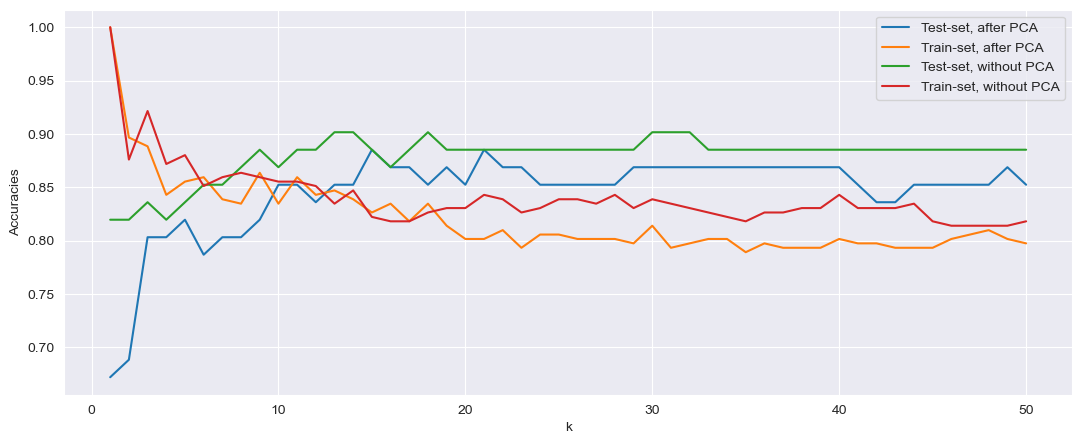

In [41]:
# Hyperparameter tuning:
# Finding the most optimal parameteres for number of neighbours
accuracies_test_pca = list()
accuracies_train_pca = list()
accuracies_test = list()
accuracies_train = list()

k = list()
for i in range(50):
    knn = KNeighborsClassifier(n_neighbors=i + 1, p=1, metric='minkowski')
    knn.fit(X_train_pca, y_train)
    t_pred_pca = knn.predict(X_test_pca)
    accuracy_test_pca = knn.score(X_test_pca, y_test)
    accuracy_train_pca = knn.score(X_train_pca, y_train)

    knn.fit(X_train, y_train)
    t_pred = knn.predict(X_test)
    accuracy_test = knn.score(X_test, y_test)
    accuracy_train = knn.score(X_train, y_train)

    accuracies_test_pca.append(accuracy_test_pca)
    accuracies_train_pca.append(accuracy_train_pca)
    accuracies_test.append(accuracy_test)
    accuracies_train.append(accuracy_train)
    k.append(i + 1)

plt.figure(figsize=(13, 5))
plt.plot(k, accuracies_test_pca, "-", label="Test-set, after PCA")
plt.plot(k, accuracies_train_pca, "-", label="Train-set, after PCA")
plt.plot(k, accuracies_test, "-", label="Test-set, without PCA")
plt.plot(k, accuracies_train, "-", label="Train-set, without PCA")
plt.ylabel("Accuracies")
plt.xlabel("k")
plt.legend()
plt.grid(1)

print(
    f"Highest accuracy of Test-set without PCA: {max(accuracies_test)}, with k value of: {k[accuracies_test.index(max(accuracies_test))]}")
print(
    f"Highest accuracy of Test-set with PCA: {max(accuracies_test_pca)}, with k value of :{k[accuracies_test_pca.index(max(accuracies_test_pca))]}")



Accuracy score for Test-set (Opitmized): 0.869
Accuracy score for Train-set (Optimized): 0.789
Precision: 0.87
Recall: 0.869
F1 Score: 0.885
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



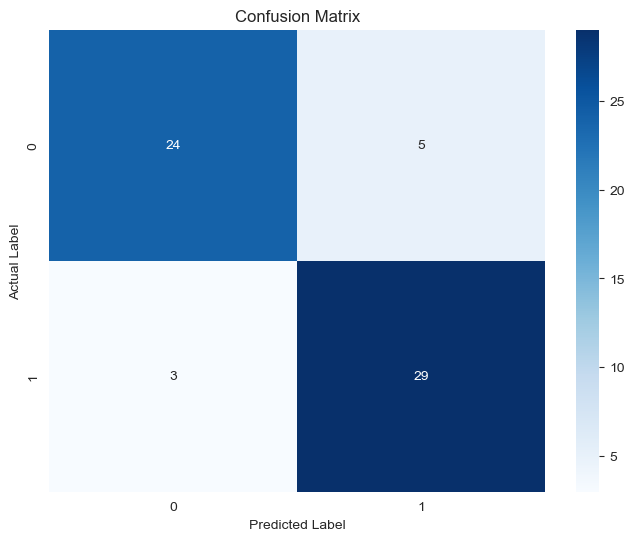

In [42]:
# Final optimized knn model
knn2 = KNeighborsClassifier(n_neighbors=35, p=1, metric='minkowski')
knn2.fit(X_train_pca, y_train)
t_pred = knn2.predict(X_test_pca)

accuracy_test_optimized = knn2.score(X_test_pca, y_test)
accuracy_train_optimized = knn2.score(X_train_pca, y_train)

print(f"Accuracy score for Test-set (Opitmized): {np.round(accuracy_test_optimized, 3)}")
print(f"Accuracy score for Train-set (Optimized): {np.round(accuracy_train_optimized,3)}")

precision = precision_score(y_test, t_pred, average='weighted')
recall = recall_score(y_test, t_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {np.round(precision,3)}")
print(f"Recall: {np.round(recall,3)}")
print(f"F1 Score: {np.round(f1,3)}")
print("Classification Report:\n", classification_report(y_test, t_pred))


conf_matrix = confusion_matrix(y_test, t_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification model 3: Random Forest

Training data accuracy: 0.93
Test data accuracy: 0.84


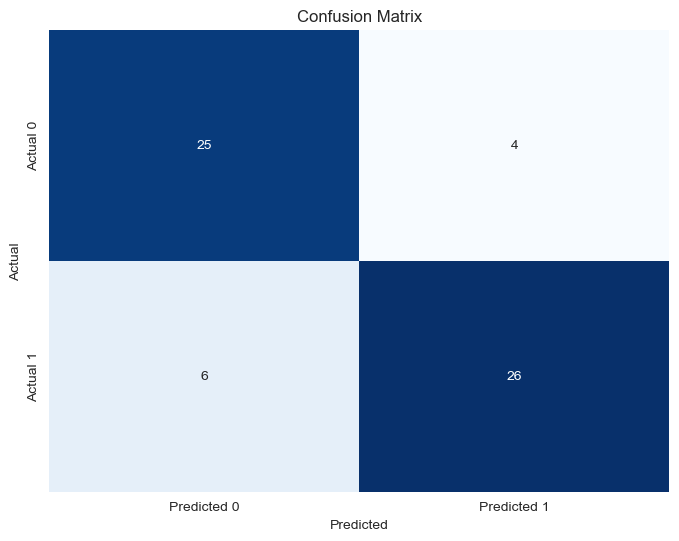

In [44]:
forest = RandomForestClassifier(random_state=42)

# Grid search for finding the best parameteres
rf_params = {
    'n_estimators': [100, 300, 700],  # Number of trees
    'max_depth': [10, 20, 30],             # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],         # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2']       # Number of features to consider at each split
}

gs_random = GridSearchCV(estimator=forest, param_grid=rf_params, cv=5, n_jobs=-1, verbose=2)
gs_random.fit(X_train_pca, y_train)

# Fitting the Random Forest model with the best parameters
forest2 = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)
forest2.fit(X_train_pca, y_train)

# Prediction
y_pred_RF = forest2.predict(X_test_pca)

# Evaluate the performance of model
forest_train_accuracy = forest2.score(X_train_pca, y_train)
forest_test_accuracy = forest2.score(X_test_pca, y_test)

print(f'Training data accuracy: {forest_train_accuracy:.2f}')
print(f'Test data accuracy: {forest_test_accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Classification model 4: SVM

In [45]:
# Creating a dataframe with selected PCs for the training data
pcaDF_train = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Creating a dataframe with selected PCs for the test data
pcaDF_test = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

#Initialize the SVM model with an RBF kernelon PCA transformed trainign data (you can choose other kernels like linear and poly but given data nature here we are using RBF)
svmModel = SVC(kernel='rbf', probability=True, random_state=42)
svmModel.fit(pcaDF_train, y_train)

#Evaluation after training has been done
# Make predictions on the test set
y_pred = svmModel.predict(pcaDF_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8689
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
[[25  4]
 [ 4 28]]


In [46]:
# Tuning SVM model
# Defining basic pipeline with StandardScaler, PCA, and SVM to perform grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization
    ('pca', PCA(n_components=6)),  # PCA with the selected number of components
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # SVM
])

# Performing 5-fold cross-validation on the entire dataset
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Output the individual fold scores
print(f'Cross-Validation Scores: {cv_scores}')

# Output the mean accuracy and standard deviation
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}')
print(f'Standard Deviation of Cross-Validation Accuracy: {cv_scores.std():.4f}')



# Define the pipeline with StandardScaler, PCA, and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Standardization
    ('pca', PCA(n_components=6)),
    ('svm', SVC(probability=True))  # SVM
])

# Expanding the parameter grid for more comprehensive tuning
paramGrid = {
    'svm__C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],  # Kernel coefficient
    'svm__kernel': ['rbf', 'poly', 'sigmoid']  # Different kernel types
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=paramGrid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the GridSearch to the data
grid_search.fit(X_train_pca, y_train)

# Print the best parameters and the best accuracy score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy:.4f}')

# Print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_test, y_pred))


Cross-Validation Scores: [0.7704918  0.8852459  0.81967213 0.88333333 0.76666667]
Mean Cross-Validation Accuracy: 0.8251
Standard Deviation of Cross-Validation Accuracy: 0.0518
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Best Cross-Validation Accuracy: 0.8432
Accuracy on Test Set: 0.8689
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### Final Comparison

                 Model  Test Accuracy
0  K-Nearest Neighbors       0.868852
1  Logistic Regression       0.885246
2        Random Forest       0.836066
3     SVM (RBF Kernel)       0.868852


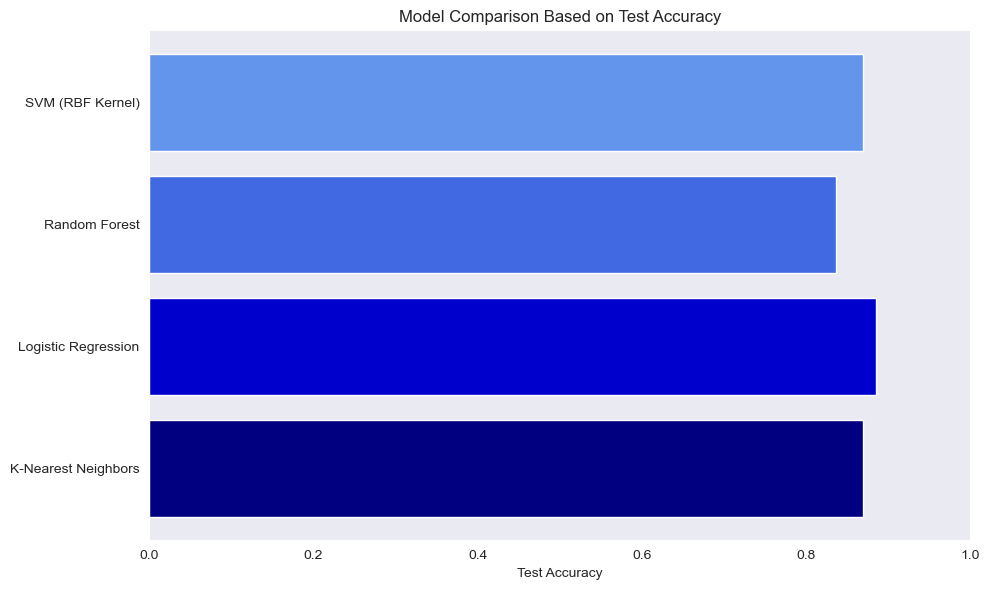

In [47]:
# The modell names and corresponding accuracy values
model_names = ["K-Nearest Neighbors", "Logistic Regression", "Random Forest", "SVM (RBF Kernel)"]
accuracies = [knn_accuracy_test, accuracy_elastic, forest_test_accuracy, svm_accuracy]

performance_df = pd.DataFrame({
    "Model": model_names,
    "Test Accuracy": accuracies
})

# Printing table showing accuracy scores
print(performance_df)

# Plotting the accuracies of the models
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color=['navy', 'mediumblue', 'royalblue', 'cornflowerblue'])
plt.xlabel('Test Accuracy')
plt.title('Model Comparison Based on Test Accuracy')
plt.xlim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(False)
plt.tight_layout()
plt.show()